In [24]:
import os
import csv
import gym
import argparse
import numpy as np
import pickle
import pyvirtualdisplay
from livelossplot import PlotLosses

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from dqn_agent import DQNAgent

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
ENV_NAME_TRAIN = 'LunarLander-v2' ## CartPole-v0, MountainCar-v0, LunarLander-v2
RENDER_TRAIN = False

NUM_TRAIN_EPS = 1000
NUM_MEM_FILL_EPS = 10

DISCOUNT = 0.99
BATCHSIZE = 64
MEMORY_CAPACITY = 5000
UPDATE_FREQUENCY = 1000

EPS_MAX = 1.0
EPS_MIN = 0.01
EPS_DECAY = 0.99

TRAIN_SEED = 12321

In [3]:
if os.environ.get('BINDER_SERVICE_HOST'): # test if running in Binder or locally
    _display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    _ = _display.start()

In [4]:
def get_display_screen(env):
    env.reset()
    return plt.imshow(env.render(mode='rgb_array')) # only call this once

In [5]:
def render_env(env, display_screen):
    display_screen.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [6]:
def set_seeds(env, seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)
    env.action_space.np_random.seed(seed)

In [7]:
def fill_memory(env, dqn_agent):
    for _ in range(NUM_MEM_FILL_EPS):
        done = False
        state = env.reset()

        while not done:
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            dqn_agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)

In [8]:
def train_loop(env, dqn_agent, display_screen, results_basepath, render=False):
    
    liveloss = PlotLosses()
    logs = {}
    
    reward_history = []
    epsilon_history = []
    loss_history = []

    step_cnt = 0
    best_score = -np.inf

    for ep_cnt in range(NUM_TRAIN_EPS):
        done = False
        state = env.reset()

        ep_score = 0

        while not done:
            if display_screen is not None:
                render_env(env=env, display_screen=display_screen)
            action = dqn_agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            dqn_agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)
            loss = dqn_agent.learn(BATCHSIZE)
            loss_history.append(loss)

            if step_cnt % UPDATE_FREQUENCY == 0:
                dqn_agent.update_target_net()

            state = next_state
            ep_score += reward
            step_cnt += 1
            
            #logs['train loss'] = loss

        epsilon_history.append(dqn_agent.epsilon)
        dqn_agent.update_epsilon()

        reward_history.append(ep_score)
        current_avg_score = np.mean(reward_history[-100:]) # get average of last 100 scores
        
        #logs['train reward'] = ep_score
        logs['train avg score'] = current_avg_score
        logs['train epsilon'] = epsilon_history[-1]

        print('Ep: {}, Total Steps: {}, Ep: Score: {}, Avg score: {}; Epsilon: {}'.format(ep_cnt, 
                                                                                          step_cnt, 
                                                                                          ep_score, 
                                                                                          current_avg_score, 
                                                                                          epsilon_history[-1]))
        
        if current_avg_score >= best_score:
            dqn_agent.save_models('{}/policy_model_best'.format(results_basepath))
            best_score = current_avg_score
            
        liveloss.update(logs)
        liveloss.send()

In [10]:
results_basepath_train = "results/{}_epsmax{}_epsmin{}_epsdec{}_batchsize{}_treps{}_memeps{}".format(
                                                                                                ENV_NAME_TRAIN,
                                                                                                EPS_MAX, 
                                                                                                EPS_MIN, 
                                                                                                EPS_DECAY, 
                                                                                                BATCHSIZE,
                                                                                                NUM_TRAIN_EPS,
                                                                                                NUM_MEM_FILL_EPS)
os.makedirs(results_basepath_train, exist_ok=True)

env_train = gym.make(ENV_NAME_TRAIN)
set_seeds(env_train, TRAIN_SEED)

dqn_agent_train = DQNAgent(device, 
                            env_train.observation_space.shape[0], 
                            env_train.action_space.n, 
                            discount=DISCOUNT, 
                            eps_max=EPS_MAX, 
                            eps_min=EPS_MIN, 
                            eps_decay=EPS_DECAY,
                            memory_capacity=MEMORY_CAPACITY)

display_screen_train = None
if RENDER_TRAIN:
    display_screen_train = get_display_screen(env_train)

In [11]:
#fill_memory(env_train, dqn_agent_train) 
#train_loop(env_train, dqn_agent_train, display_screen_train, results_basepath_train)

In [21]:
#RESULTS_BASEPATH_TEST = 'results/CartPole-v0_epsmax1.0_epsmin0.01_epsdec0.99_batchsize64_treps1000_memeps10'
#RESULTS_BASEPATH_TEST = 'dqn_res/LunarLander-v2_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64_treps2000'
RESULTS_BASEPATH_TEST = 'dqn_res/MountainCar-v0_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64'

#ENV_NAME_TEST = 'CartPole-v0'
#ENV_NAME_TEST = 'LunarLander-v2'
ENV_NAME_TEST = 'MountainCar-v0'

RENDER_TEST = False

NUM_TEST_EPS = 100
TEST_SEED = 456
#TEST_SEED = [456, 12, 985234, 123, 3202]

In [22]:
def test_loop(env, agent, display_screen, results_basepath):
    liveloss = PlotLosses()
    logs = {}
    
    step_cnt = 0
    reward_history = []

    for ep in range(NUM_TEST_EPS):
        score = 0
        done = False
        state = env.reset()
        while not done: # and step_cnt<1000:
            if display_screen is not None:
                env.render()
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            state = next_state
            step_cnt += 1
            
        reward_history.append(score)
        logs['test score'] = score
        liveloss.update(logs)
        liveloss.send()
        
        #print('Ep: {}, Score: {}'.format(ep, score))

    with open('{}/test_reward_history_{}_bleh.pkl'.format(results_basepath, TEST_SEED), 'wb') as f:
        pickle.dump(reward_history, f)

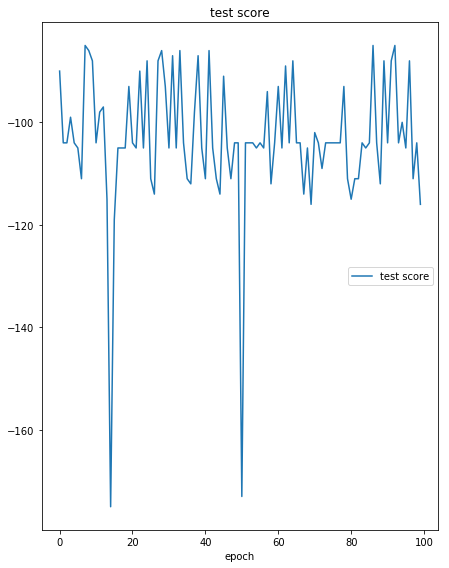

test score
	test score       	 (min: -175.000, max:  -85.000, cur: -116.000)


In [23]:
env_test = gym.make(ENV_NAME_TEST)
set_seeds(env_test, TEST_SEED)

dqn_agent_test = DQNAgent(device=device, 
                          state_size=env_test.observation_space.shape[0], 
                          action_size=env_test.action_space.n,
                          discount=0.0, 
                          eps_max=0.0, 
                          eps_min=0.0, 
                          eps_decay=0.0,
                          memory_capacity=0,
                          train_mode=False)
dqn_agent_test.load_model('{}/policy_model_best'.format(RESULTS_BASEPATH_TEST))

display_screen_test = None
if RENDER_TEST:
    display_screen_test = get_display_screen(env_test)

test_loop(env=env_test, 
          agent=dqn_agent_test, 
          display_screen=display_screen_test, 
          results_basepath=RESULTS_BASEPATH_TEST)